In [2]:
import torch
import torch.cuda
import numpy as np

In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # torch.device('cpu') # 
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import random
seed_everything(random.randint(1, 10000))

In [5]:
import torchtext.datasets

train_iter, test_iter  = torchtext.datasets.AG_NEWS()

In [6]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def build_vocabulary(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary([train_iter]), min_freq=3, specials=["<UNK>"])

vocab.set_default_index(vocab["<UNK>"])
len(vocab)

40708

In [7]:
def save_vocab(vocab):
    import pickle
    output = open('vocab.pkl', 'wb')
    pickle.dump(vocab, output)
    output.close()

save_vocab(vocab)

In [8]:
from torchtext.data.functional import to_map_style_dataset

train_dataset, test_dataset  = to_map_style_dataset(train_iter), to_map_style_dataset(test_iter)

target_classes = ["World", "Sports", "Business", "Sci/Tech"]

max_words = 50

In [9]:
train_dataset[3]

(3,
 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.')

In [10]:
train_dataset[10000]

(1,
 'A Daily Look at U.S. Iraq Military Deaths (AP) AP - As of Wednesday, Aug. 25, 964 U.S. service members have died since the beginning of military operations in Iraq in March 2003, according to the Defense Department. Of those, 722 died as a result of hostile action and 242 died of non-hostile causes.')

In [11]:
from torch.utils.data import DataLoader
def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(text)) for text in X]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] 

    return torch.tensor(X, dtype=torch.int32).to(device), (torch.tensor(Y) - 1).to(device) 

batch_size = 512 
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=batch_size, collate_fn=vectorize_batch)

In [12]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

In [14]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        b = torch.tensor(losses).mean()
        c = accuracy_score(Y_shuffled.detach().cpu().numpy(), Y_preds.detach().cpu().numpy())
        print("Test Loss  : {:.3f}".format(b))
        print("Test Acc   : {:.3f}\n".format(c))
        return b, c

def train_model(model, loss_fn, optimizer, train_loader, test_loader, epochs=10, test=False):
    a_ = []
    b_ = []
    c_ = []
    for i in range(1, epochs + 1):
        losses = []
        #for X, Y in tqdm(train_loader):
        for X, Y in train_loader:
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        a = torch.tensor(losses).mean()
        a_.append(a.item())
        print("Train Loss : {:.3f}".format(a))
        if test:
            b, c = CalcValLossAndAccuracy(model, loss_fn, test_loader)
            b_.append(b.item())
            c_.append(c.item())
    return a_, b_, c_

def make_predictions(model, loader):
    Y_shuffled, Y_preds = [], []
    with torch.no_grad():
        for X, Y in loader:
            preds = model(X)
            Y_preds.append(preds)
            Y_shuffled.append(Y)
        gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().cpu().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().cpu().numpy()

def print_results(Y_actual, Y_preds, target_names):
    print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
    print("\nClassification Report : ")
    print(classification_report(Y_actual, Y_preds, target_names=target_classes))
    print("\nConfusion Matrix : ")

    from sklearn.metrics import confusion_matrix
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    import numpy as np

    skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Purples",
                                        hide_zeros=True,
                                        figsize=(5,5)
                                        )
    plt.xticks(rotation=90)

def save_model(model, name):
    path = './net_'+ name +'.pth'
    print(path)
    torch.save(model.state_dict(), path)

In [15]:
embed_len = max_words
hidden_dim = 50
n_layers = 1

class RNN_1(nn.Module):
    def __init__(self):
        super(RNN_1, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.rnn = nn.RNN(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(target_classes))
        self.dropout = nn.Dropout(0.25)
        #self.hidden = torch.nn.parameter.Parameter(torch.zeros(n_layers, batch_size, self.hidden_dim, device=device))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)

        output, hidden = self.rnn(embeddings, torch.randn(n_layers, len(X_batch), hidden_dim, device=device))
        output = self.linear(output)
        return output[:,-1]
    
get_n_params(RNN_1())

2040704

In [16]:
from torch.optim import Adam

epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = RNN_1().to(device)
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

a, b, c = train_model(rnn_classifier, loss_fn, optimizer, train_loader, test_loader, epochs, test=True)
save_model(rnn_classifier, 'rnn_simple')
gc.collect()
torch.cuda.empty_cache()

Train Loss : 1.354
Test Loss  : 1.304
Test Acc   : 0.361

Train Loss : 1.207
Test Loss  : 1.131
Test Acc   : 0.452

Train Loss : 1.078
Test Loss  : 1.034
Test Acc   : 0.479

Train Loss : 0.983
Test Loss  : 0.971
Test Acc   : 0.498

Train Loss : 0.892
Test Loss  : 0.825
Test Acc   : 0.631

Train Loss : 0.726
Test Loss  : 0.691
Test Acc   : 0.685

Train Loss : 0.637
Test Loss  : 0.639
Test Acc   : 0.699

Train Loss : 0.592
Test Loss  : 0.634
Test Acc   : 0.698

Train Loss : 0.564
Test Loss  : 0.622
Test Acc   : 0.722

Train Loss : 0.535
Test Loss  : 0.585
Test Acc   : 0.742

Train Loss : 0.472
Test Loss  : 0.502
Test Acc   : 0.822

Train Loss : 0.407
Test Loss  : 0.485
Test Acc   : 0.839

Train Loss : 0.370
Test Loss  : 0.445
Test Acc   : 0.856

Train Loss : 0.342
Test Loss  : 0.444
Test Acc   : 0.858

Train Loss : 0.317
Test Loss  : 0.457
Test Acc   : 0.854

./net_rnn_simple.pth


Test Accuracy : 0.8536842105263158

Classification Report : 
              precision    recall  f1-score   support

       World       0.90      0.85      0.88      1900
      Sports       0.93      0.96      0.94      1900
    Business       0.76      0.86      0.81      1900
    Sci/Tech       0.84      0.74      0.79      1900

    accuracy                           0.85      7600
   macro avg       0.86      0.85      0.85      7600
weighted avg       0.86      0.85      0.85      7600


Confusion Matrix : 


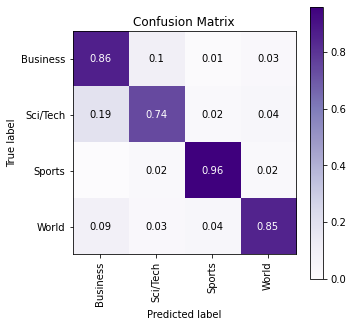

In [17]:
Y_actual, Y_preds = make_predictions(rnn_classifier, test_loader)
print_results(Y_actual, Y_preds, target_classes)

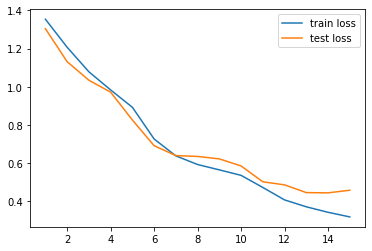

In [18]:
t = range(1, 16)
plt.figure()
plt.plot(t, a, label='train loss')
plt.plot(t, b, label ='test loss')
plt.legend(loc='best')
plt.show()

In [19]:
embed_len = max_words
hidden_dim_1 = 40
hidden_dim_2 = 50
hidden_dim_3 = 60
n_layers = 1

class RNN_2(nn.Module):
    def __init__(self):
        super(RNN_2, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.rnn1 = nn.RNN(input_size=embed_len, hidden_size=hidden_dim_1, num_layers=1, batch_first=True)
        self.rnn2 = nn.RNN(input_size=hidden_dim_1, hidden_size=hidden_dim_2, num_layers=1, batch_first=True)
        self.rnn3 = nn.RNN(input_size=hidden_dim_2, hidden_size=hidden_dim_3, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_dim_3, len(target_classes))
        self.dropout = nn.Dropout(0.25)
        #self.hidden = torch.nn.parameter.Parameter(torch.zeros(n_layers, batch_size, self.hidden_dim, device=device))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)

        output, hidden = self.rnn1(embeddings, torch.randn(n_layers, len(X_batch), hidden_dim_1, device=device))
        output, hidden = self.rnn2(output, torch.randn(n_layers, len(X_batch), hidden_dim_2, device=device))
        output, hidden = self.rnn3(output, torch.randn(n_layers, len(X_batch), hidden_dim_3, device=device))

        output = self.linear(output)
        return output[:,-1]
    
get_n_params(RNN_2())

2050644

In [20]:
epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier_layers = RNN_2().to(device)
optimizer = Adam(rnn_classifier_layers.parameters(), lr=learning_rate)

a, b, c = train_model(rnn_classifier_layers, loss_fn, optimizer, train_loader, test_loader, epochs, test=True)
save_model(rnn_classifier_layers, 'rnn_layers')
gc.collect()
torch.cuda.empty_cache()

Train Loss : 1.361
Test Loss  : 1.251
Test Acc   : 0.403

Train Loss : 1.097
Test Loss  : 1.020
Test Acc   : 0.498

Train Loss : 1.050
Test Loss  : 1.039
Test Acc   : 0.486

Train Loss : 0.980
Test Loss  : 0.967
Test Acc   : 0.492

Train Loss : 0.920
Test Loss  : 0.945
Test Acc   : 0.527

Train Loss : 0.810
Test Loss  : 0.781
Test Acc   : 0.657

Train Loss : 0.657
Test Loss  : 0.617
Test Acc   : 0.762

Train Loss : 0.682
Test Loss  : 0.711
Test Acc   : 0.731

Train Loss : 0.825
Test Loss  : 0.816
Test Acc   : 0.633

Train Loss : 0.761
Test Loss  : 0.745
Test Acc   : 0.676

Train Loss : 0.764
Test Loss  : 1.115
Test Acc   : 0.478

Train Loss : 0.927
Test Loss  : 0.899
Test Acc   : 0.595

Train Loss : 0.857
Test Loss  : 0.897
Test Acc   : 0.638

Train Loss : 0.792
Test Loss  : 0.762
Test Acc   : 0.694

Train Loss : 0.830
Test Loss  : 0.760
Test Acc   : 0.707

./net_rnn_layers.pth


Test Accuracy : 0.854078947368421

Classification Report : 
              precision    recall  f1-score   support

       World       0.90      0.85      0.88      1900
      Sports       0.93      0.96      0.94      1900
    Business       0.76      0.86      0.81      1900
    Sci/Tech       0.84      0.75      0.79      1900

    accuracy                           0.85      7600
   macro avg       0.86      0.85      0.85      7600
weighted avg       0.86      0.85      0.85      7600


Confusion Matrix : 


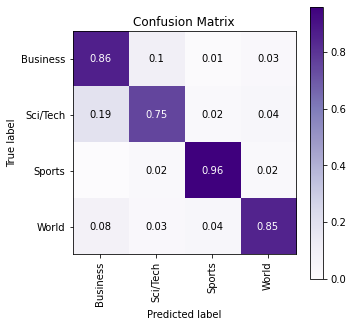

In [21]:
Y_actual, Y_preds = make_predictions(rnn_classifier, test_loader)
print_results(Y_actual, Y_preds, target_classes)

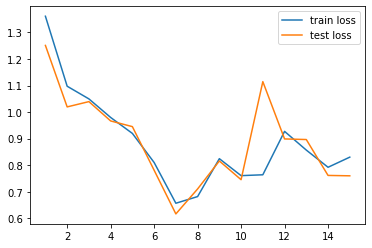

In [22]:
t = range(1, 16)
plt.figure()
plt.plot(t, a, label='train loss')
plt.plot(t, b, label ='test loss')
plt.legend(loc='best')
plt.show()